In [78]:
!pip install -U gensim

In [198]:
import codecs # Word encoding
import glob # regex
import multiprocessing # multithreading
import os
import pprint
import re
import nltk # toeknize sentence
import gensim.models.word2vec as w2v # word2vec
import sklearn.manifold #dimensionality reduction
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # visualization

In [199]:
#Path here
path = "Data/the_big_short.txt"

In [200]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Abhishek\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [201]:
nltk.download('punkt') # pretrained tokenizer
nltk.download('stopwords') # remove (and or the a an)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhishek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abhishek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [202]:
#initialize rawunicode
corpus = u""

In [203]:
# read it as utf 8 format, 
# add it to the raw corpus
print("Reading '{0}'...".format(path))
with codecs.open(path, "r", "utf-8") as book_file:
    corpus += book_file.read()
with codecs.open(path, "r", "utf-8") as book_file:
    corpus += book_file.read()
with codecs.open(path, "r", "utf-8") as book_file:
    corpus += book_file.read()
print("Corpus is now {0} characters long".format(len(corpus)))

Reading 'Data/the_big_short.txt'...
Corpus is now 1613808 characters long


In [204]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [205]:
raw_sentences = tokenizer.tokenize(corpus)

Clean the sentence and split it to word

In [206]:
#remove symbols and split word
def sentence_to_wordlist(raw):
    clean_sentences = re.sub("[^a-zA-Z]"," ", raw) 
    words = clean_sentences.split()
    return words

In [207]:
sentences = []
for rs in raw_sentences:
    if len(rs) > 0:
        sentences.append(sentence_to_wordlist(rs))

Print out example

In [208]:
print(raw_sentences[50])
print(sentence_to_wordlist(raw_sentences[50]))

The vast assemblages of highly paid people inside them were worth, in her view, nothing.
['The', 'vast', 'assemblages', 'of', 'highly', 'paid', 'people', 'inside', 'them', 'were', 'worth', 'in', 'her', 'view', 'nothing']


Count tokens, each one being a sentence

In [209]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 285,267 tokens


In [210]:
features = 300 # more dimensions = more training, more accurate

min_word_count = 3 # Minimum word count threshold.

workers_count = multiprocessing.cpu_count() # Number of threads to run in parallel.

context_size = 7 # Context window length.

# Downsample setting for frequent words.
# rate 0 to 1e-5 
#how often to use
downsampling = 1e-3

seed = 1 # Random number generator

In [211]:
model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=workers_count,
    size=features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [212]:
model.build_vocab(sentences)

In [213]:
print("Word2Vec vocabulary length:", len(model.wv.vocab))

Word2Vec vocabulary length: 7604


In [214]:
#model.train(sentences, total_examples=17277, epochs=100)

Saving model

In [215]:
model.save(os.path.join("TrainedModel/", "model.w2v"))

Loading model

In [216]:
model = w2v.Word2Vec.load(os.path.join("TrainedModel/", "model.w2v"))

Squash dimensionality to 2 so data can be plotted easily

In [217]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

Put it all into a giant matrix

In [218]:
all_word_vectors_matrix = model.wv.syn0

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence

In [219]:
#train t sne
#time consuming step
#all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [220]:
#plot point in 2d space

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [221]:
points.head(10)

,word,x,y
0,The,-37.267200,-27.184193
1,Big,16.119665,-17.209494
2,Short,22.051903,25.804768
3,Also,38.184399,15.514509
4,by,-30.961884,-10.682173
5,Michael,23.072817,45.711323
6,Lewis,-13.848553,0.199086
7,Home,-2.329591,4.475601
8,Game,16.781212,22.153406
9,Liar,35.677486,11.514467


In [222]:
sns.set_context("poster")

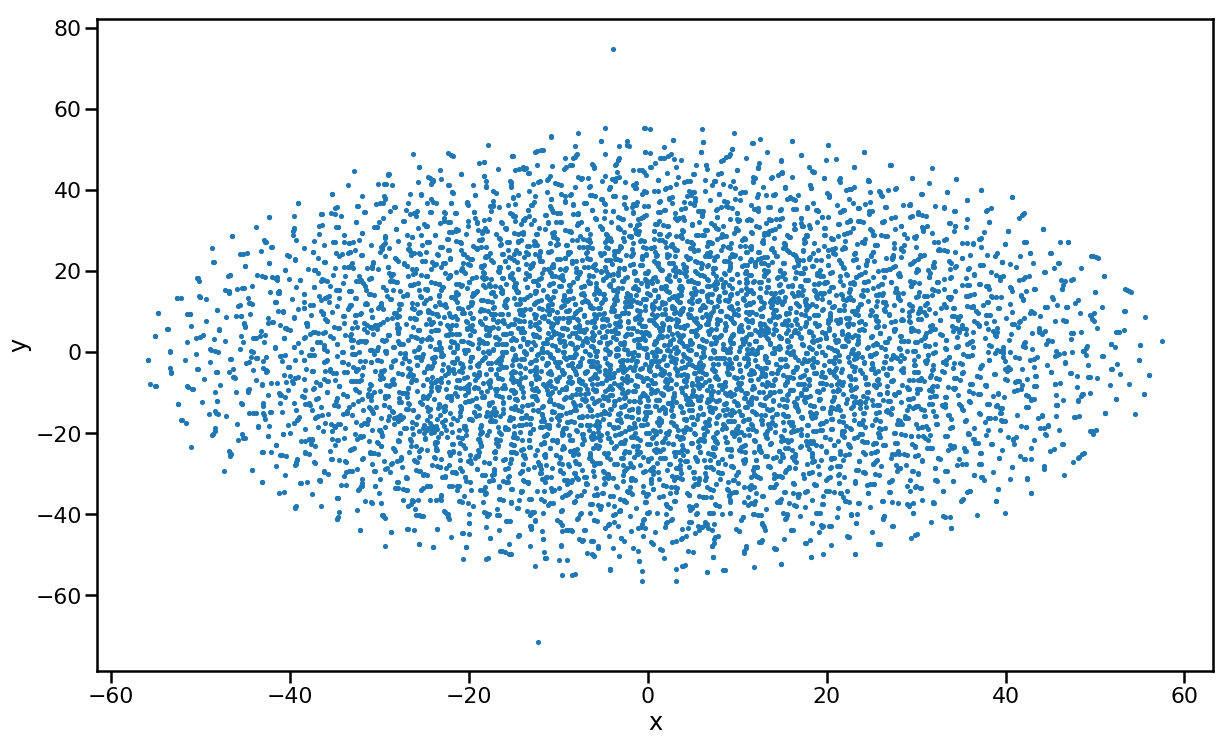

In [223]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [224]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

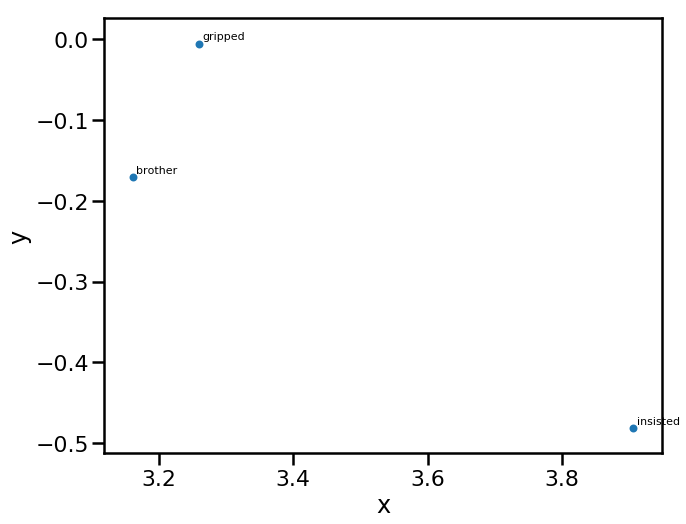

In [225]:
plot_region(x_bounds=(2.5, 4), y_bounds=(-0.8, 0))

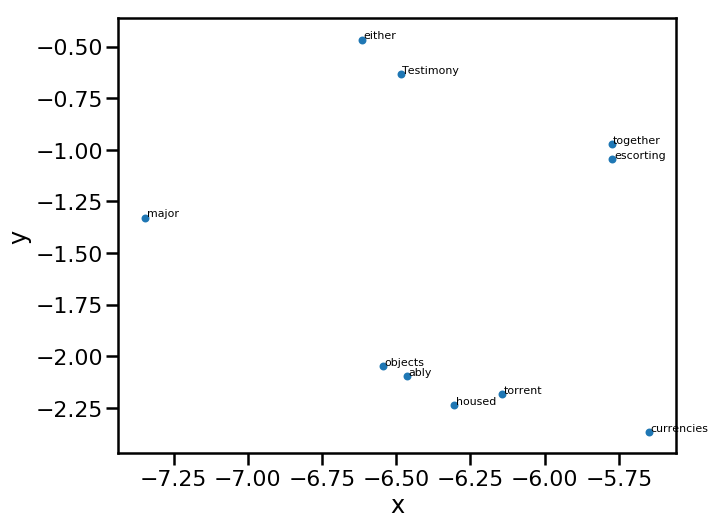

In [226]:
plot_region(x_bounds=(-7.5, -5), y_bounds=(-2.5, 0))

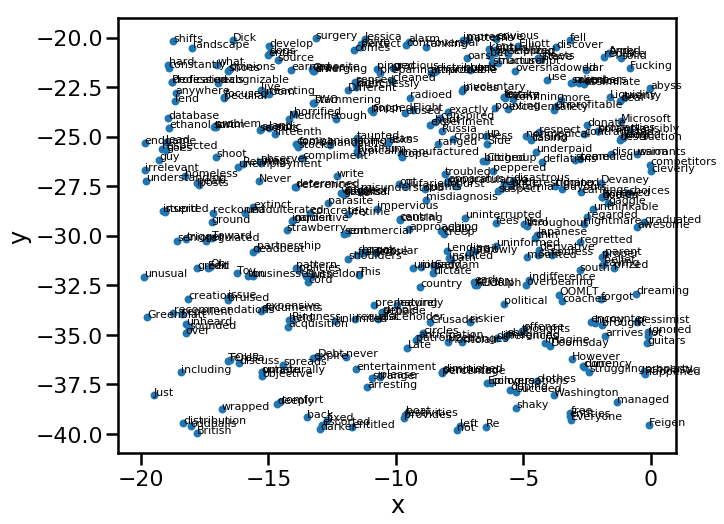

In [227]:
plot_region(x_bounds=(-20.0, 0), y_bounds=(-40, -20))

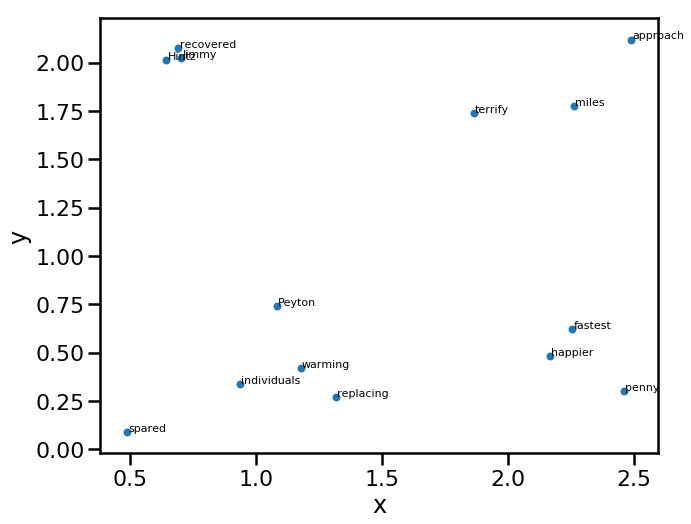

In [228]:
plot_region(x_bounds=(0, 2.5), y_bounds=(0, 2.5))

In [229]:
model.wv.most_similar("fraud")

C:\Users\Abhishek\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('locked', 0.20696908235549927),
 ('seated', 0.19454054534435272),
 ('chumps', 0.19185270369052887),
 ('diapers', 0.19064366817474365),
 ('passed', 0.1896420121192932),
 ('fatally', 0.18603795766830444),
 ('PowerPoint', 0.18495197594165802),
 ('chairs', 0.18040603399276733),
 ('Minister', 0.17753395438194275),
 ('yelled', 0.1755000650882721)]

# Linear relationships between word pairs

In [230]:
#distance, similarity, and ranking
def nearest_similarity(start1, end1, end2):
    similarities = model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

man to woman, doctor to nurse 

In [231]:
nearest_similarity("fools", "lacked", "powerful")

fools is related to lacked, as sufficiently is related to powerful


'sufficiently'

In [232]:
nearest_similarity("action", "Chinese", "American")

action is related to Chinese, as King is related to American


'King'

In [233]:
nearest_similarity("careful", "positive", "negative")

careful is related to positive, as published is related to negative


'published'

In [234]:
nearest_similarity("lawsuit", "problematic", "panic")

lawsuit is related to problematic, as midprime is related to panic


'midprime'